# Machine Learning with Applications

###### Matteo Martinelli - 962371, a.y. 2020-2021

### Introduction
This project's goal is to study correlations in a dataset of Diamonds, and trying to build a model that, given the diamonds most important features, is able to predict correctly the price.  
The dataset is wide, it consists of 53940 different rows (corresponding to different diamonds) and 11 different columns, which are either categorical or numerical features. As I mentioned before, the target variable is the _price_ while other characteristic will be considered as predictors.

### Pre-processing
Before starting to study the dataset I loaded it in a DataFrame, exploiting _Pandas_ library. I deleted the column _Unnamed_ which was only the index of the row, therefore useless for this project. I also checked for any missing values in any column, but they were all completely filled. Then I looked for any unphysical data, such as value 0 for any of the 3 dimension of the diamond, and I eliminated the correspondent rows.  
Afer that I changed the name of some variables, in order to be clearer.

In [1]:
#Data organization and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#ML
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

DEF_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
RS = 7 #RandomState variable setted here to reproduce same results

In [2]:
#Loading data
fileName = "diamonds.csv"
df = pd.read_csv(fileName)
df = df.drop("Unnamed: 0", axis=1)
df = df.rename(columns={ 'depth' : 'tot%depth', 'x' : 'length', 'y' : 'width', 'z' : 'depth'})
#Check for missing values
print(np.all(df.isnull().sum() == 0))

df = df.drop(df[df.length==0.0].index)
df = df.drop(df[df.width ==0.0].index)
df = df.drop(df[df.depth ==0.0].index)

True


In [3]:
#Visualize data
display(df)

,carat,cut,color,clarity,tot%depth,table,price,length,width,depth
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


After the elimination of 0 values data the dataset now consists in 53920 rows.  
To explain the meaning of the variables I referred to the [Kaggle](https://www.kaggle.com/shivam2503/diamonds) dataset documentation and to the [Tiffany Guide to Diamonds](https://www.tiffany.com/engagement/the-tiffany-guide-to-diamonds/).  
Beginning from the first 4 variables `carat`, `cut`, `color` and `clarity` - or _the 4 C's_, as they're usually called -, they are the weight of the diamonds (1 carat = 0.2g), the quality of the human work that has shaped the diamond, the natural tint inherent in white diamond and a measure of the purity of the stone when watched under 10-power magnification. Following are the charts explaing these 3 categorical variables. It is important to underline that this charts provide values in order from better to worst.  

<img src="GTD_Cut.jpeg" alt="Diamonds Cut Chart" width = "33%" align="left"/> 
<img src="GTD_Color.jpeg" alt="Diamonds Color Chart" width = "33%" align="left"/> 
<img src="GTD_Clarity.jpeg" alt="Diamonds Clarity Chart" width = "33%" align="left"/>

`tot%depth`, `table`, `length`, `width` and `depth` are instead numerical quantities related to the shape of the diamond. The first one is a combination of the last 3, namely $tot\%d = 2\frac{d}{l+w}$ and is expressed in percentage. The second is also expressed as a percentage relatively to the widest part. The last 3 are expressed in _mm_, and are the actual spatial dimension of the diamond. The image below shows better what this feature refers to.
<img src="Table_depth_diamond.png" alt="Diamonds table and depth" width = "33%"/>

After loading the dataset I wanted to study distribution of categorical variables, to understand if there was any asymmetry in it. As is it clear form the following histograms both `cut` and `clarity` have a little amount of values in one or two classes. This probably will affect the prediction when based on one of this feature.  
After this I renamed this categorical variables as numbers, in order to account for them in the algorithm I will use later on in this notebook. This is possible only because, even though they are categorical, this 3 variables have an intrinsic order, as explained before, and therefore we can maintain this order when assigning them an integer value.

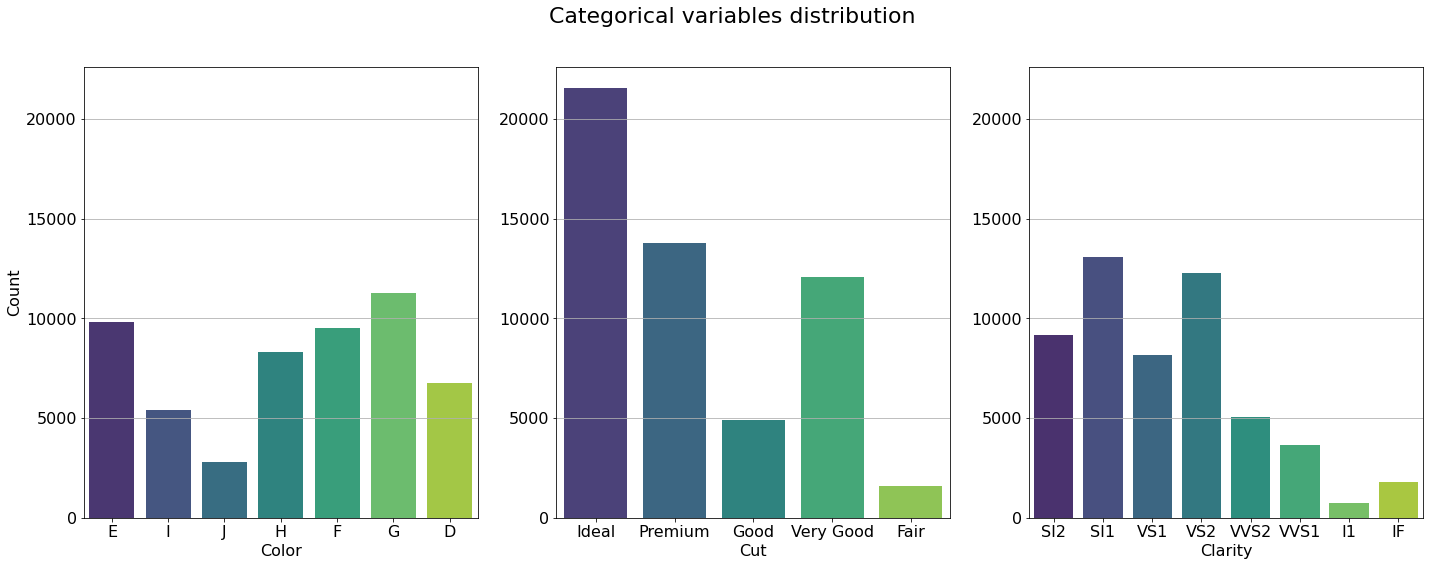

In [4]:
#Visualize categorical data distribution

fig = plt.figure(figsize=(24, 8.3))
fig.suptitle("Categorical variables distribution", fontsize=22)


ax1=plt.subplot(131)
g = sns.countplot(x='color', data=df, palette="viridis")
ax1.set_xlabel("Color",fontsize=16)
ax1.set_ylabel("Count", fontsize=16)

ax2=plt.subplot(132, sharey=ax1)
g2 = sns.countplot(x='cut', data=df, palette="viridis")
ax2.set_xlabel("Cut",fontsize=16)
ax2.get_yaxis().get_label().set_visible(False)

ax3=plt.subplot(133, sharey=ax1)
g3 = sns.countplot(x='clarity', data=df, palette="viridis")
ax3.set_xlabel("Clarity",fontsize=16)
ax3.get_yaxis().get_label().set_visible(False)

for ax in [ax1, ax2, ax3]:
    ax.tick_params(labelsize=16)
    ax.grid(True, axis = 'y')

In [5]:
#Preprocessing
#Replacing String values with numbers

#Increasing order for Cut
#Fair, Good, Very Good, Premium, Ideal
cuts = {'Fair'  : 1, 
        'Good'  : 2, 
        'Very Good' : 3, 
        'Premium'   : 4,
        'Ideal' : 5}
for c in cuts.keys():
    df['cut'] = df['cut'].replace(c, cuts[c])


#Increasing order for Clarity
#I1 , SI2, SI1, VS2, VS1, VVS2, VVS1, IF
clarity = {'I1'   : 1,
   'SI2'  : 2,
   'SI1'  : 3,
   'VS2'  : 4,
   'VS1'  : 5,
   'VVS2' : 6,
   'VVS1' : 7,
   'IF'   : 8}

for c in clarity.keys():
    df['clarity'] = df['clarity'].replace(c, clarity[c])


#Increasing order for color
col = df['color'].unique()
col.sort()
col = col[::-1]
#Replacing with numbers
i = 1
for c in col:
    df['color'] = df['color'].replace(c, i)
    i +=1

After categorical variables I plotted the distribution of `price` which is the target variable. We can see from the histogram that it is not a symmetrical, instead it is peaked in the range of low prices and decays fast with the increasing of the price. This may produce some issues in the regression for predicting prices, and should be therefore accounted for.

Text(0.5, 1.0, 'Price Distribution')

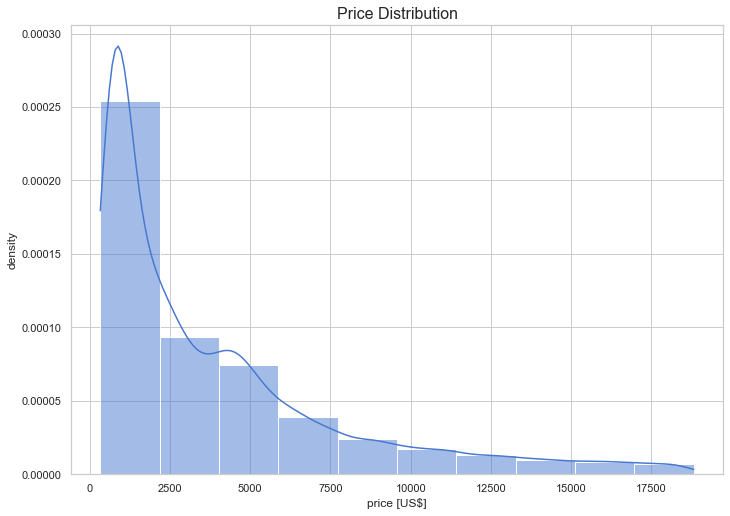

In [6]:
#Price distributions among the dataset
sns.set(style = 'whitegrid', rc={'figure.figsize':(11.7,8.27)}, palette='muted')
ax = sns.histplot(df['price'], bins=10, kde=True, stat='density')
ax.set_ylabel("density")
ax.set_xlabel("price [US$]")
ax.set_title("Price Distribution", fontsize=16)

The following step is to study pair correlations between the dataset variables. The results are reported in the picture. We can see that there are 4 variables strongly correlated to the target, `carat`, `length`, `width`, `depth`. As we expected the weight and the dimension of the diamond are correlated with price.  
It is interesting to notice also that the 3 spatial dimensions, which in principle could be independent, are instead correlated one to each other. It is probably due to the fact that this diamonds, from what we can infere from their dimensions, are meant to be sold on a ring, and therefore must respect some proportion between each direction.  

<AxesSubplot:>

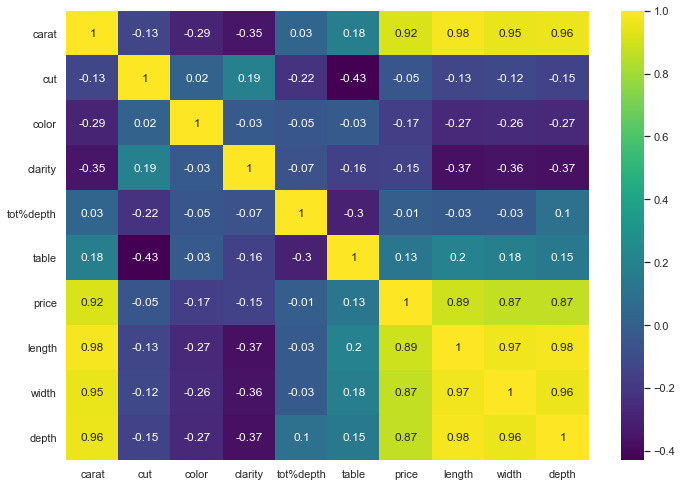

In [7]:
#Studying correlation matrix
cMat = df.corr().round(2)
sns.heatmap(data=cMat, annot=True, cmap='viridis')

### Linear Regression
Since there are strong pair correlation in the dataset I began by studying a linear regression model using all predictors.  
This model assumes that ouput variables $\boldsymbol{y}$ are a function of input variables $\boldsymbol{x}$ s as:
$$y = f(\boldsymbol{x}) + \epsilon$$
where $\epsilon$ is a stochastic error, usually distributed as a Normal $\mathcal{N}(0, \sigma^2)$ and it is irreducible, and the goal is to find the set of parameters $\boldsymbol\beta$ such that:
$$\hat{y} = \hat f (\boldsymbol{x}) = \boldsymbol{x^T\boldsymbol\beta}$$
is the best approximation of the output.

The problem therefore is minimizing the _Ordinary Least Square_ cost function:
$$ \min_{\boldsymbol\beta \in \mathbb{R}^p} \left\{
\frac{1}{N} (\boldsymbol{y} - \boldsymbol{\hat{y}})^T 
(\boldsymbol{y} - \boldsymbol{\hat{y}})
\right\}$$


And the solution, expressed in terms of _design matrix_, is obtained strightforward:
$$\boldsymbol{\beta} =\left(\boldsymbol{X}^T\boldsymbol{X}\right)^{-1}\boldsymbol{X}^T\boldsymbol{y}$$

Before implementing the linear regression we have two issues to face:
 - First we have the target output not well distributed across the range it spaces, thus leading to problems in predicting accurately the biggest prices. In order to avoid this problem we so decided to transform the output variable `price` with its log, making the distribution far more symmetrical
 - The second problem is that, using all the predictors, we have strong correlation in our deisgn matrix which could lead to problems in inverting the matrix $\left(\boldsymbol{X}^T\boldsymbol{X}\right)^{-1}$. So we added a regularization term to prevent this possibility.
 
Regularization terms such as _Ridge_ or _LASSO_ consist in adding a little quantity to the cost function, more precisely:  
Ridge: 
$ \quad C(\boldsymbol\beta) \rightarrow C(\boldsymbol\beta) + \lambda \boldsymbol\beta^T\boldsymbol\beta$  
LASSO:
$ \quad C(\boldsymbol\beta) \rightarrow C(\boldsymbol\beta) + \lambda \sum_{i=1}^p |\beta_i|$  
being $\lambda$ the shrinkage parameter.  
This reflects in a slightly different solution for $\boldsymbol\beta$ which does not have problem in being computed due to non-invertible matrices.

Text(0.5, 1.0, 'log(Price) Distribution')

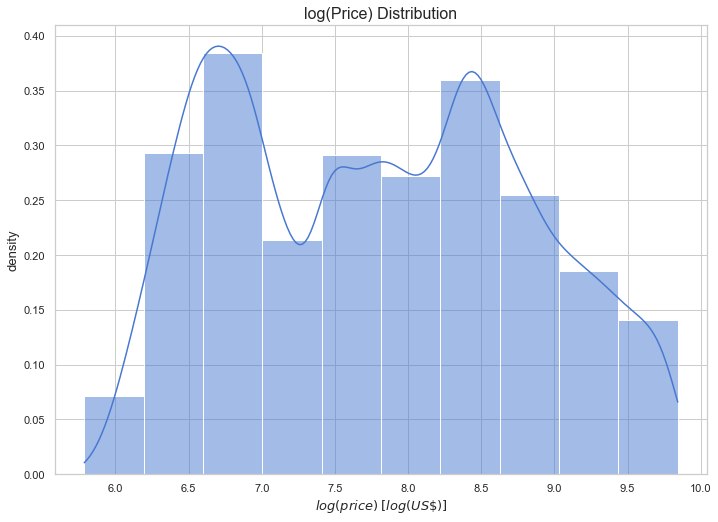

In [8]:
#New price distributions among the dataset
sns.set(style = 'whitegrid', rc={'figure.figsize':(11.7,8.27)}, palette='muted')
ax = sns.histplot(np.log(df['price']), bins=10, kde=True, stat='density')
ax.set_ylabel("density", fontsize=13)
ax.set_xlabel(f"$log(price)$ $[log(US\$)]$", fontsize=13)
ax.set_title("log(Price) Distribution", fontsize=16)

I started splitting the dataset in 80% training set and the remaining 20% for tests.  
After that I trained both a LASSO and a Ridge regressor with differen values for the shrinking parameter $\lambda$

In [9]:
#First we select predictors and targets, transforming the last
#And divide train and test data

X = df[['carat', 'cut', 'color', 'clarity', 'tot%depth',
            'table', 'length', 'width', 'depth']]
logY = np.log(df['price'])
X_train, X_test, logY_train, logY_test = train_test_split(X, logY, test_size = 0.2, random_state=RS)

In [10]:
from sklearn.linear_model import Ridge, Lasso


lambdas = [0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

r_train, r_test = [], []
l_train, l_test = [], []
r_test_p, l_test_p = [], []

l_values  = "Lambdas|       |"
ridge_res = " Ridge | Train |"
ridge_tes = "  r2   | Test  |" 
lasso_res = " LASSO | Train |"
lasso_tes = "  r2   | Test  |" 


for i,l in enumerate(lambdas):
    
    ri = Ridge(alpha=l).fit(X_train, logY_train)
    la = Lasso(alpha=l).fit(X_train, logY_train)
    
    #TRAIN
    y_r_p = ri.predict(X_train)
    y_l_p = la.predict(X_train)

    r_train.append(r2_score(logY_train, y_r_p))
    l_train.append(r2_score(logY_train, y_l_p))
    ridge_res +="{:.3f}|".format(r_train[i])
    lasso_res +="{:.3f}|".format(l_train[i])
    
    #TEST
    r_test_p.append(ri.predict(X_test))
    l_test_p.append(la.predict(X_test))

    r_test.append(r2_score(logY_test, r_test_p[i]))
    l_test.append(r2_score(logY_test, l_test_p[i]))
    ridge_tes +="{:.3f}|".format(r_test[i])
    lasso_tes +="{:.3f}|".format(l_test[i])
    
    l_values += " {:.1f} |".format(l)
    
print(l_values)
print("----------------------------------------------------------------------------")
print(ridge_res)
print(ridge_tes)
print("----------------------------------------------------------------------------")
print(lasso_res)
print(lasso_tes)

Lambdas|       | 0.1 | 0.2 | 0.3 | 0.4 | 0.5 | 0.6 | 0.7 | 0.8 | 0.9 | 1.0 |
----------------------------------------------------------------------------
 Ridge | Train |0.978|0.978|0.978|0.978|0.978|0.978|0.978|0.978|0.978|0.978|
  r2   | Test  |0.978|0.978|0.978|0.978|0.978|0.978|0.978|0.978|0.978|0.978|
----------------------------------------------------------------------------
 LASSO | Train |0.937|0.892|0.853|0.799|0.730|0.644|0.544|0.428|0.296|0.149|
  r2   | Test  |0.937|0.891|0.852|0.797|0.727|0.642|0.542|0.426|0.295|0.148|


We notice that while the Ridge method is stable for all the values of the parameter, the LASSO becomes worser as the shrinkage increases; we therefore conclude that in this case, the Ridge regression is the most accurate, and it also shows a very high degree of accuracy, scoring **0.978** for the test set for every value of $\lambda$.  
For this reason I seleced the $\lambda = 0.1$ Ridge as the best model, as it is the one with the lowest shrinkage. Remembering that I transformed the target variable I wanted to see if it was possible to go back to real values, with a sufficiently degree of accuracy.  
I plotted the prediction against the real values of the target, which in a perfect modelling should be distributed across the bisector of the first quadrant. 
I also computed the $R^2$ score of the predicted values, transformed back to real prices with the actual targets. We see that accuracy decreases a little bit, becoming 0.943, yet still it is a good result

True r2 score = 0.943


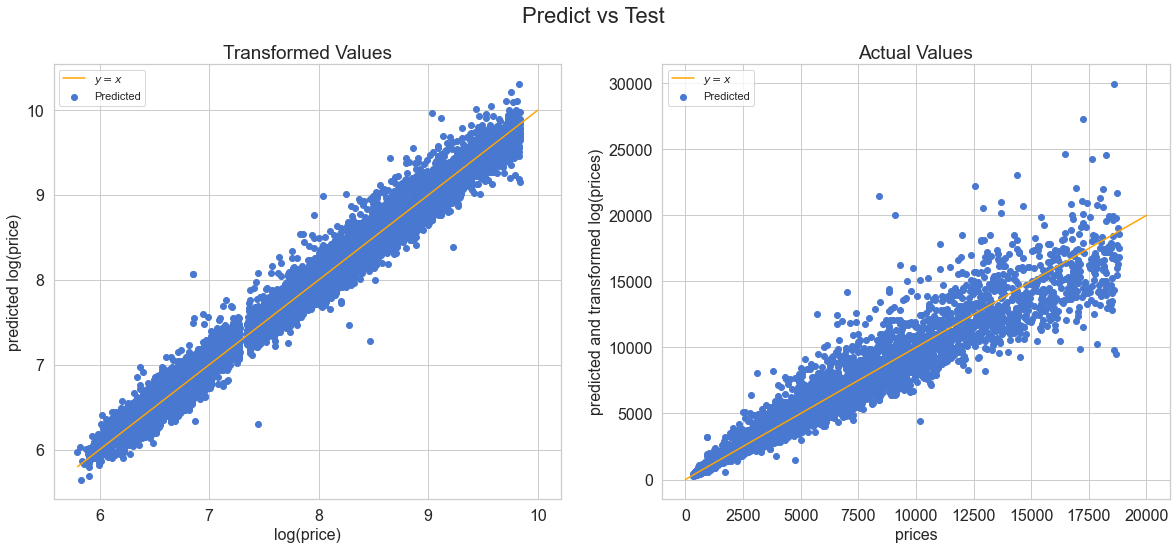

In [11]:
# plotting the y_test vs y_pred
# we want it to be the 1st quadrant bisector
fs = 16
best_i = 0
fig, ax = plt.subplots(1, 2, figsize= (20, 8))
fig.suptitle("Predict vs Test", fontsize=22)

ax[0].scatter(logY_test, r_test_p[best_i], label='Predicted')
ax[0].plot(np.arange(5.8, 10.1,0.2), np.arange(5.8, 10.1,0.2), color='orange', label=r'$y= x$')

ax[0].set_title("Transformed Values", fontsize=19)
ax[0].set_xlabel("log(price)", fontsize=fs)
ax[0].set_ylabel("predicted log(price)", fontsize=fs)

ax[0].tick_params(labelsize=fs)
ax[0].legend()

prices = df['price']
_, _, _, real_Y = train_test_split(X, prices, test_size = 0.2, random_state=RS)
ax[1].scatter(real_Y, np.exp(r_test_p[best_i]), label='Predicted')
ax[1].plot(np.arange(0, 20000), np.arange(0, 20000), color='orange', label=r'$y= x$')

ax[1].set_title("Actual Values", fontsize=19)
ax[1].set_xlabel("prices", fontsize=fs)
ax[1].set_ylabel("predicted and transformed log(prices)", fontsize=fs)

ax[1].tick_params(labelsize=fs)
ax[1].legend()


print("True r2 score = {:.3f}". format(r2_score(real_Y, np.exp(r_test_p[best_i]))))
plt.show()

We can see that prediction are enough close to real values, except for few outliers. We also notice that with the increasing in price there is a kind of widening along the quadrant bisector. This is probably due to the logarithmic transformation that has been applied to targets, indeed errors in the prediction, when transformed back, results in being exponentially increased and multiplied to the real values, therefore the bigger the value, the bigger the error. To clarify this I present the following explanation:  
From linear regression we obtain 
$$
\hat{y}_1 = f(\boldsymbol{x_1}) + \eta 
$$
where $\eta$ is the error we commit in the extimation of the ouput.
But this is the $log$ of the price, so we transform it back, obtaining:
$$
\hat{p}_1 = e^{y_1} = e^\eta e^{ f(\mathbf{x_1})}
$$
Given the real price $p_1$ (ignoring the irreducible error), the distance from the prediction is:
$$
p_1-\hat{p}_1 =  e^{ f(\boldsymbol{x_1})}(1 - e^\eta)
$$
Which clearly increases when $f(\boldsymbol{x_1})$ does so.  
I like to underline the fact that the error can be either over/under estimation, but when it is $\eta>0$ then the error exponentially grows as we can see in the outliers above 30k of predicted price

### Linear Regression 2

The result from the Ridge regressor is satisfying, but I wanted to explore if it was possible to do better, maybe also using less predictors.  
Therefore I decided to train another Linear regressor, without any regularization term. To do so I had to eliminate from the inputs all the strong correlated variables but one. I trained 4 different regressor using only one variable from `carat`, `length`, `width` and `depth` at a time.

In [12]:
#We drop the correlated predictors and rebuild train and model data

X_lr = {}
X_lr_train = {}
X_lr_test = {}

for f in ['length', 'width', 'depth', 'carat']:
    #Add only one of this 4 features in each set
    X_lr[f] =  df[['cut', 'color', 'clarity', 'tot%depth',
    'table',f]]
    X_lr_train[f], X_lr_test[f], _, _= train_test_split(X_lr[f], logY, test_size = 0.2, random_state=RS)

In [13]:
lr = {}
y_lr_train_p = {}
y_lr_test_p = {}
#print("Linear Regression\n")
print("Feature | Train | Test  |")
print("-------------------------")
for f in ['length', 'width', 'depth', 'carat']:
    lr[f] = LinearRegression().fit(X_lr_train[f], logY_train)

    # TRAIN

    y_lr_train_p[f] = lr[f].predict(X_lr_train[f])
    rmse = (np.sqrt(mean_squared_error(logY_train, y_lr_train_p[f])))
    r2 = lr[f].score(X_lr_train[f], logY_train)
    
    res = " {}\t| {:.3f} |".format(f, r2)
    # TEST

    y_lr_test_p[f] = lr[f].predict(X_lr_test[f])
    # root mean square error of the model
    rmse = (np.sqrt(mean_squared_error(logY_test, y_lr_test_p[f])))

    # r-squared score of the model
    r2 = lr[f].score(X_lr_test[f], logY_test)
    
    print(res + " {:.3f} |".format(r2))

Feature | Train | Test  |
-------------------------
 length	| 0.967 | 0.969 |
 width	| 0.902 | 0.962 |
 depth	| 0.923 | 0.963 |
 carat	| 0.879 | 0.884 |


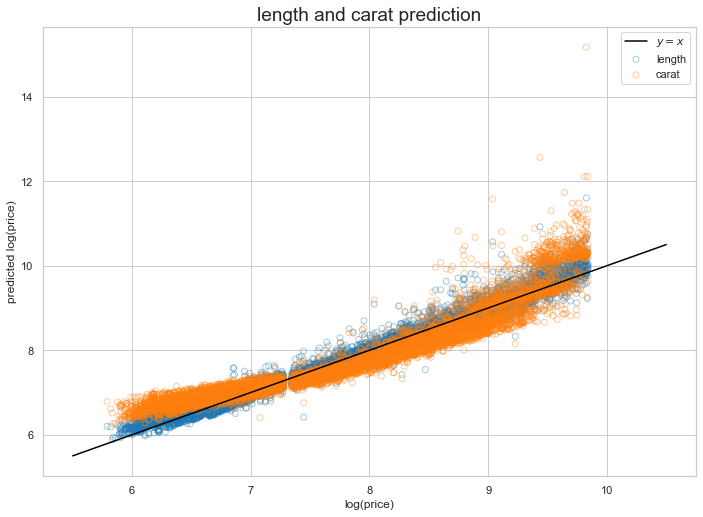

In [14]:
# plotting the y_test vs y_pred
# ideally should have been a straight line
i =0
for f in ['length', 'carat']:
    plt.scatter(logY_test, y_lr_test_p[f], label=f, alpha=0.4, facecolors='none', edgecolors=DEF_COLORS[i] )
    i +=1
plt.plot(np.arange(5.5, 11), np.arange(5.5,11), color='black', label=r'$y= x$')
plt.legend()
plt.title("length and carat prediction", fontsize = 19)
plt.xlabel("log(price)")
plt.ylabel("predicted log(price)")
plt.show()

Decreasing the number of feature as expected does not improve the accuracy of the prediction, because using less predictors means we are eliminating some information from the system. What is unexpected, in my opinion, and - I must say - interesting, is that the feature that helps the most in predicting the price is not `carat`, but `length`. Not only, we see that accuracy using only `carat` is the worst.
We can assume that by dropping `length`, `width` and `depth` we have lost almost all the information about the spatial dimension of the diamond, which surely is important in defining the price (in the simplest way: _the bigger the diamond, the higher the price_).  
However we must admit that one of this 4 features is enough to obtain a satisfying result in predictions, because, as we could expect, the dimension of the diamond is what matter the most in defining its price. This offers the spark for instead studying how other features affect the price with equal dimensions or weight. This study will be carried out further in this notebook.

### Decision Tree Regressor

Linear regressors has offered a very good model for prediction, but I had to transform the target value, and this reflected in having an increasing error, which is not desirable. Therefore I decided to perform different algorthms to make better predictions, without transforming the target. I started from a Decision Tree Regressor. 

A decision tree regressor is an algorithm that by subsequent binary splittings along one axis in the space of parameters, divides this spaces in regions and assignes a constant value to the points belonging to it.  

3 important parameters to set when training a Decision Tree Regressore are:
 - **criterion**: The function to measure the quality of a split, here I used the Mean Squared Error cost function
 - **min_samples_leaf**: the minimum number of samples required to be at a leaf node. This is very important in a regressor, because tuning this parameter correctly can lead to a smooth predict funcion, otherwise the risk of overfitting is really high.
 - **ccp_alpha**: the _pruning_ parameter
 
The pruning technique is meant to reduce the size of a tree, without worsening too much its prediction, in order to avoid overfitting. In `sklearn` module the implementation of the pruning is the Minimal Cost-Complexity Pruning.  
It consists in defining the cost-complexity measure:
$$ R_{\alpha}(T) = R(T) + \alpha|T|$$
where $R(T)$ is the cost function of the tree $T$, and $|T|$ is the number of terminal nodes in $T$.
For each node $t$ the cost $R_{\alpha}(t) = R(t) + \alpha$ is defined. Now, given $T_t$ the subtree whose root is the node $t$, the algorithm defines $\alpha_{eff}$ as the value of $\alpha$ for which the cost of the node is equal to the cost of the subtree, namely $R_{\alpha}(t) = R_{\alpha}(T_t)$.
The smallest value of $\alpha_{eff}$ for a non-terminal node identifies link to prune, and it is done so only if $\alpha_{eff}$ is less than `ccp_alpha`.

I trained a Decision Tree Regressor choosing different values for `ccp_alpha` and `min_samples_leaf`.

In [15]:
X = df[['cut', 'color', 'clarity', 'tot%depth', 'table','length']]
Y = df['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=RS)

In [16]:
%%time
from sklearn.tree import DecisionTreeRegressor
#different RS for Tree
RS2 = 1
ccps = [0.0, 0.001, 0.01, 0.1, 0.5, 1.0]
min_leafs = [3, 5, 7, 10, 12, 15, 20, 25]
r2_train_dt = np.zeros((len(ccps),len(min_leafs)))
r2_test_dt = np.zeros((len(ccps),len(min_leafs)))

best_score = 0.0
for i,c in enumerate(ccps):
    for j,l in enumerate(min_leafs):
        dt = DecisionTreeRegressor(min_samples_leaf=l, criterion='mse', random_state=RS2, ccp_alpha=c)
        dt.fit(X_train, Y_train)
        # TRAIN
        r2_train_dt[i,j] = dt.score(X_train, Y_train)
        # TEST
        r2_test_dt[i,j] = dt.score(X_test, Y_test)
        
        if r2_test_dt[i,j] > best_score:
            y_test_p_dt = dt.predict(X_test)
            best_c, best_l, best_score = c, l, r2_test_dt[i,j]
print("cpp_alpha = \t{}".format(best_c))
print("min_leaf = \t{}".format(best_l))
print("r2 test score = {:.4f}".format(best_score))

cpp_alpha = 	1.0
min_leaf = 	10
r2 test score = 0.9719
CPU times: user 4.81 s, sys: 36.9 ms, total: 4.85 s
Wall time: 4.86 s


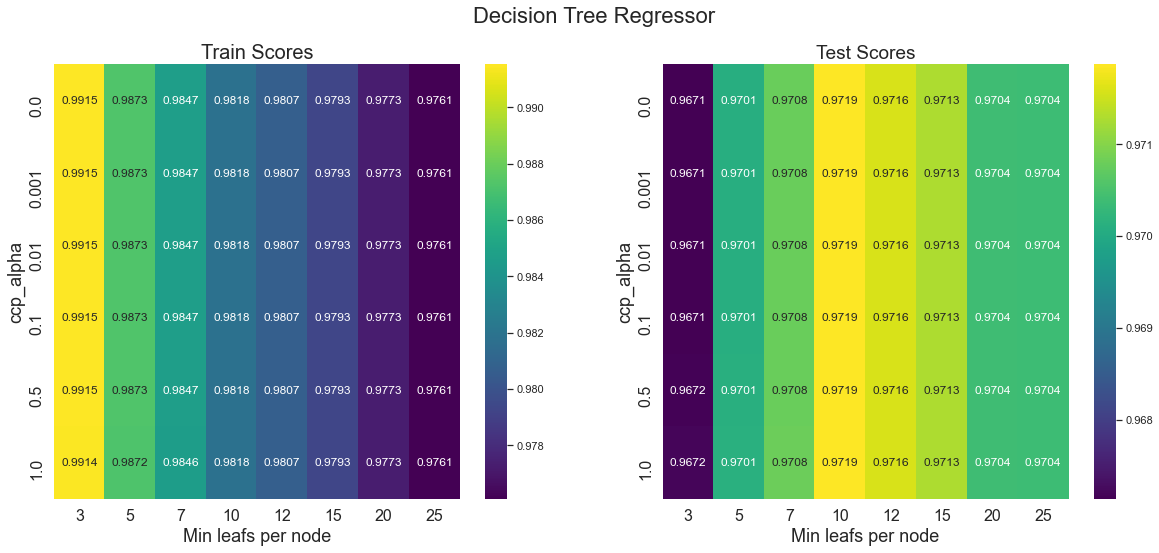

In [17]:
fs = 18
fig, ax = plt.subplots(1, 2, figsize= (20, 8))
fig.suptitle("Decision Tree Regressor", fontsize=fs+4)

ax[0] = sns.heatmap(r2_train_dt, annot=True, ax=ax[0], xticklabels = min_leafs, yticklabels=ccps, fmt='.4', cmap='viridis')

ax[0].set_title("Train Scores", fontsize=fs+2)
ax[0].set_xlabel("Min leafs per node", fontsize=fs)
ax[0].set_ylabel("ccp_alpha", fontsize=fs)

ax[0].tick_params(labelsize=fs-2)

ax[1] = sns.heatmap(r2_test_dt, annot=True, ax=ax[1], xticklabels = min_leafs, yticklabels=ccps, fmt='.4', cmap='viridis')

ax[1].set_title("Test Scores", fontsize=19)
ax[1].set_xlabel("Min leafs per node", fontsize=fs)
ax[1].set_ylabel("ccp_alpha", fontsize=fs)

ax[1].tick_params(labelsize=fs-2)


plt.show()

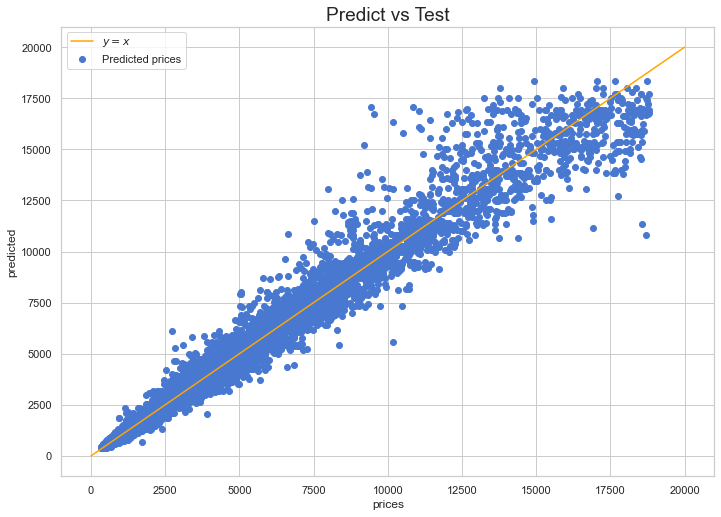

In [18]:
plt.scatter(Y_test, y_test_p_dt, label='Predicted prices')
plt.plot(np.arange(0, 20000), np.arange(0, 20000), color='orange', label=r'$y= x$')
plt.xlabel("prices")
plt.ylabel("predicted")
plt.title("Predict vs Test", fontsize=19)
plt.legend()
plt.show()

From the scores we can say that for this problem pruning is not necessary, as fixing the `min_samples_leaf` the accuracy does not change for a wide range of values for the pruning parameter.
We also find that the best result is achieved with `min_samples_leaf` of 10, which means that we have smoothed a while our regression.
Of course as we obtained a high accuracy with the simple Linear Regression, the improvements that can be reach with other regressors will not be great in magnitude, but they will be considered significant if in the order of $10^{-2}$-$10^{-3}$. With the decision tree the accuracy incremented by 0.3% with respect to the simple linear regression without all the correlated variables, and therefore it means that this is a slightly better algorithm for prediction of diamonds price. 
Also I want to highlight that with this results had been reached without transforming the target variable, and this reflects - as we can see from the scatterplot - in a fewer presence of outliers, with predictions closer to the real value.

### Random Forest Regressor

Given the results with Decision Tree I decided to boost it using a Random Forest Regressor. This is an ensemble predictor that is based on different Decision Trees that are individually trained on a bootstrap subset of the training set. Then the test is performed and the result is decided averaging the outputs of each tree. This should result in a better prediction.

Once again one important parameter to tune is the `min_samples_leaf` of the single tree.  
In the forest also the number of trees used for the prediction is an important parameter, as it is important to make a tradeoff between the accuracy achieved increasing the number of trees and the computational cost this implies.  
I decided not to use pruning in the forest because the previous results showed that it nearly doesn't affect the result.

In [19]:
%%time
from sklearn.ensemble import RandomForestRegressor

min_leafs = [3, 5, 7, 10, 12, 15]
n_trees = [10, 20, 50, 100, 500, 1000]

r2_train_rf = np.zeros((len(n_trees),len(min_leafs)))
r2_test_rf = np.zeros((len(n_trees),len(min_leafs)))


best_score = 0.0
for i,n in enumerate(n_trees):
    for j,l in enumerate(min_leafs):
        rf = RandomForestRegressor(n_estimators=n, min_samples_leaf=l, random_state=RS2)
        rf.fit(X_train, Y_train)
        # TRAIN
        r2_train_rf[i,j] = rf.score(X_train, Y_train)
        # TEST
        r2_test_rf[i,j] = rf.score(X_test, Y_test)
        
        if r2_test_rf[i,j] > best_score:
            y_test_p_rf = rf.predict(X_test)
            best_c, best_l, best_score = n, l, r2_test_rf[i,j]
print("number of trees = \t{}".format(best_c))
print("min_leaf = \t{}".format(best_l))
print("r2 test score = {:.4f}".format(best_score))

number of trees = 	1000
min_leaf = 	3
r2 test score = 0.9768
CPU times: user 8min 53s, sys: 2.11 s, total: 8min 56s
Wall time: 8min 56s


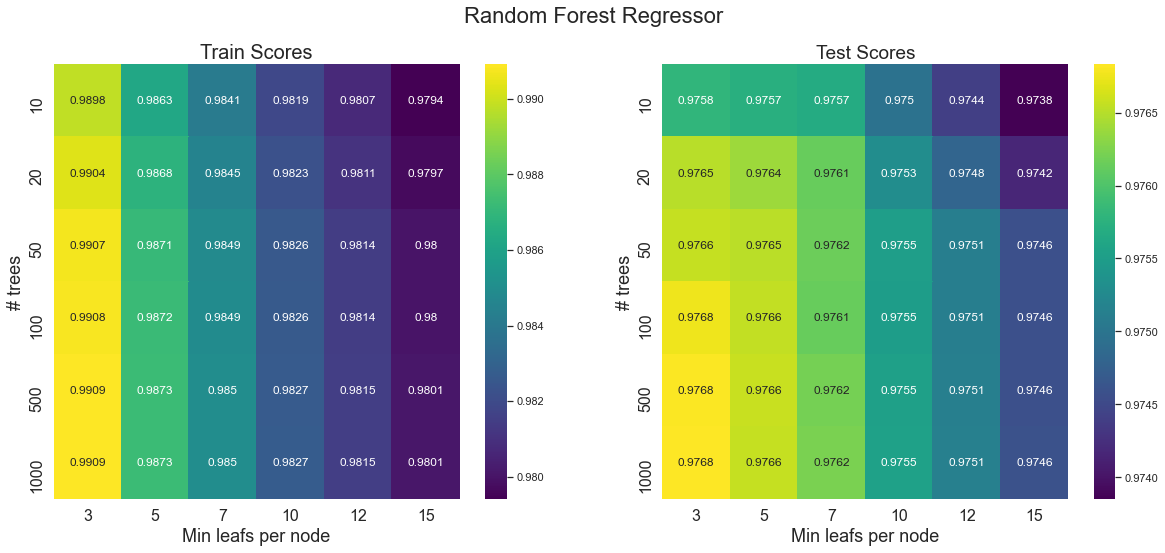

In [20]:
fs = 18
fig, ax = plt.subplots(1, 2, figsize= (20, 8))
fig.suptitle("Random Forest Regressor", fontsize=fs+4)

ax[0] = sns.heatmap(r2_train_rf, annot=True, ax=ax[0], xticklabels = min_leafs, yticklabels=n_trees, 
                    fmt='.4', cmap='viridis')

ax[0].set_title("Train Scores", fontsize=fs+2)
ax[0].set_xlabel("Min leafs per node", fontsize=fs)
ax[0].set_ylabel("# trees", fontsize=fs)

ax[0].tick_params(labelsize=fs-2)

ax[1] = sns.heatmap(r2_test_rf, annot=True, ax=ax[1], xticklabels = min_leafs, yticklabels=n_trees, 
                    fmt='.4', cmap='viridis')

ax[1].set_title("Test Scores", fontsize=19)
ax[1].set_xlabel("Min leafs per node", fontsize=fs)
ax[1].set_ylabel("# trees", fontsize=fs)

ax[1].tick_params(labelsize=fs-2)


plt.show()

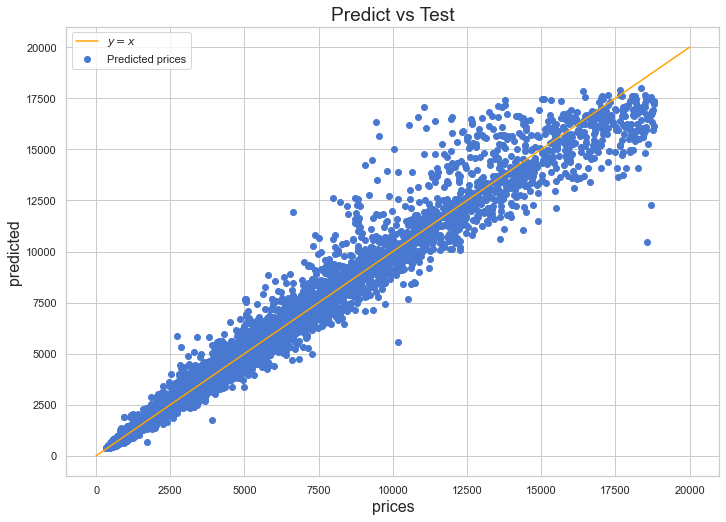

In [21]:
plt.scatter(Y_test, y_test_p_rf, label='Predicted prices')
plt.plot(np.arange(0, 20000), np.arange(0, 20000), color='orange', label=r'$y= x$')
plt.xlabel("prices", fontsize= 16)
plt.ylabel("predicted", fontsize= 16)
plt.title("Predict vs Test", fontsize=19)
plt.legend()
plt.show()

As expected averaging results of different trees improves the prediction accuracy of the model, reaching 97.7% with 1000 trees in the forest, even though we see that this result could be achieved with less trees (100 and 500 have really similar values), meaning that we probably exploited the information in the dataset as much as possible.   
It is interesting to notice that with the forest the averaging is made between values of different trees, so that it is no more necessary to smooth the model with a high value of `min_samples_leaf`, thus the best prediction results from a model with the smallest value tried for this parameter, 3, the value that fits better in a single tree.

### Price per carat

As anticipated before the strong correlation between some features and the target have given us very satisfying predictions, with accuracy above 97%.  
This also made not possible to study how other features are correlated - if any correlation exists - with price, since they play a minor role. I thus decided to introduce a 2 features in the dataset, wich are respectevely the ratio between `price` and `carat` (`ppc`) and the ratio between `price` and the product of `length`, `width` and `depth` (`ppv`), namely the cube inscribing the diamond, and trying to find if other feature do actually play a minor role in the pricing of diamonds, or are just irrelevant.


In [22]:
df['ppc'] = df['price']/df['carat']
df['ppv'] = df['price']/(df['length']*df['width']*df['depth'])

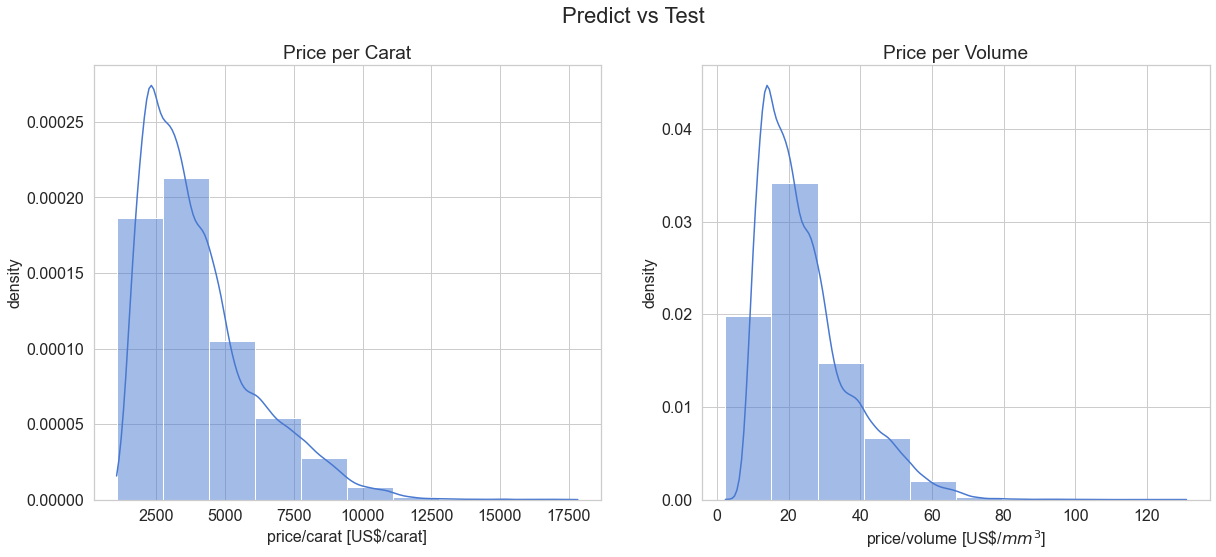

<AxesSubplot:>

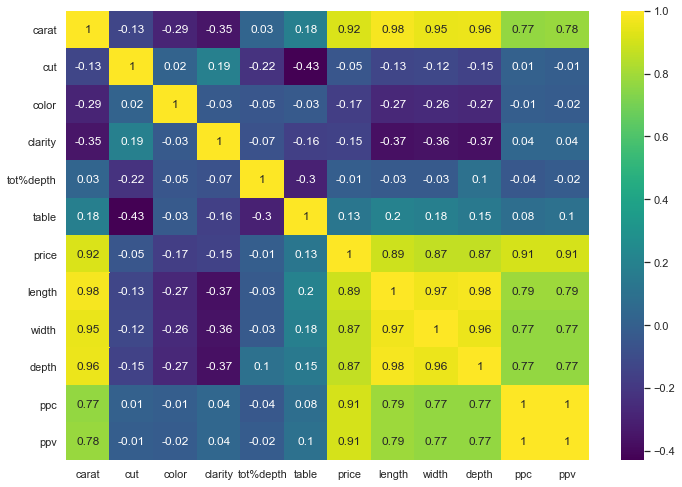

In [23]:
fs = 16
fig, ax = plt.subplots(1, 2, figsize= (20, 8))
fig.suptitle("Predict vs Test", fontsize=22)

sns.set(style = 'whitegrid', rc={'figure.figsize':(11.7,8.27)}, palette='muted')
ax[0] = sns.histplot(df['ppc'], bins=10, kde=True, stat='density', ax=ax[0])

ax[0].set_title("Price per Carat", fontsize=19)
ax[0].set_xlabel("price/carat [US$/carat]", fontsize=fs)
ax[0].set_ylabel("density", fontsize=fs)

ax[0].tick_params(labelsize=fs)

ax[1] = sns.histplot(df['ppv'], bins=10, kde=True, stat='density', ax=ax[1])

ax[1].set_title("Price per Volume", fontsize=19)
ax[1].set_xlabel(r"price/volume [US\$/$mm^3$]", fontsize=fs)
ax[1].set_ylabel("density", fontsize=fs)

ax[1].tick_params(labelsize=fs)
plt.show()

#Studying correlation matrix
cMat = df.corr().round(2)
sns.heatmap(data=cMat, annot=True, cmap='viridis')


From the plot of the distribution we see that `ppc` and `ppv` are very similar, leading to think that they bring the same information. This is highlighted also by the correlation between this 2 new variables, which is exactly 1.0. Giving that weight and volume in a diamonds are related by the mass density of the diamond itself this result could be of no surprise, still we must remember that as _volume_ we used the cube inscribing the diamond. From this correlation we can, therefore, understand that, probably, the error made in the extimation of diamond volume is the same, proportionally, for every unit in the dataset, namely the diamonds have all a similar shape.
For this reason I used as a target only `ppc`, because trying to predict also `ppv` will not be of any difference.
I did not use as variable for this prediction neither `carat` nor the 3 dimension variables, in order to inquire the meaningfullness of the other properties of the diamond, when the target is normalized with respect to the size.
I chose to train a Random Forest Regressor as it is the most solid, as emerged from previous studies.

In [24]:
#First we select predictors and targets
#And divide train and test data

X_ppc = df[['color','cut', 'clarity', 'tot%depth', 'table']]
Y_ppc = df['ppc']

X_ppc_train, X_ppc_test, Y_ppc_train, Y_ppc_test = train_test_split(X_ppc, Y_ppc, test_size = 0.2, random_state=31)

In [31]:
%%time
from sklearn.ensemble import RandomForestRegressor

min_leafs = [3, 5, 7, 10, 12, 15, 20, 25]
n_trees = 1000

r2_train_ppc = np.zeros(len(min_leafs))
r2_test_ppc = np.zeros(len(min_leafs))

best_score_ppc = 0
for j,l in enumerate(min_leafs):
    rf = RandomForestRegressor(n_estimators=n_trees, min_samples_leaf=l, random_state=RS2)
    rf.fit(X_ppc_train, Y_ppc_train)
    r2_train_ppc[j] = rf.score(X_ppc_train, Y_ppc_train)
    r2_test_ppc[j] = rf.score(X_ppc_test, Y_ppc_test)
    
    if r2_test_ppc[j] > best_score_ppc:
        y_test_p_ppc = rf.predict(X_ppc_test)
        best_l_ppc, best_score_ppc = l, r2_test_ppc[j]
print("PPC")
print("min_leaf = \t{}".format(best_l_ppc))
print("r2 test score = {:.4f}".format(best_score_ppc))
print()

PPC
min_leaf = 	20
r2 test score = 0.0700

CPU times: user 5min 8s, sys: 1.41 s, total: 5min 9s
Wall time: 5min 9s


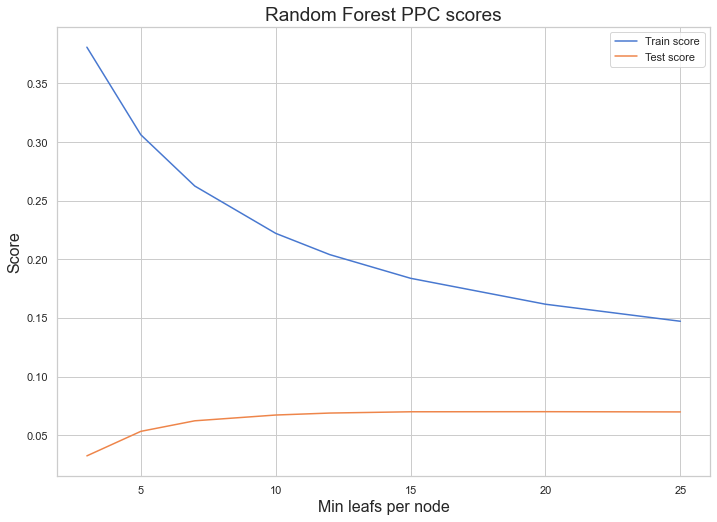

In [32]:
plt.plot(min_leafs, r2_train_ppc, label='Train score')
plt.plot(min_leafs, r2_test_ppc, label='Test score')
plt.xlabel("Min leafs per node", fontsize= 16)
plt.ylabel("Score", fontsize= 16)
plt.title("Random Forest PPC scores", fontsize=19)
plt.legend()
plt.show()

Given this not satisfying results, I tried to train an AdaBoost Regressor, which is an algorithm that step by step tries to improve the prediction of the data with the highest error, applying a greater weight to them.

In [33]:
%%time
from sklearn.ensemble import AdaBoostRegressor
n_trees = [10, 15, 20, 50, 100, 15, 500]
gammas = [0.1, 0.3, 0.5, 0.7, 1.0, 1.2, 1.5]

r2_train_ab = np.zeros((len(n_trees), len(gammas)))
r2_test_ab  = np.zeros((len(n_trees), len(gammas)))

best_score_ab = 0.0
for i,n in enumerate(n_trees):
    for j,g in enumerate(gammas):
        ab = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(min_samples_leaf=12),
                               n_estimators=n, learning_rate=g,  random_state=4)
        ab.fit(X_ppc_train, Y_ppc_train)
        r2_train_ab[i,j] = ab.score(X_ppc_train, Y_ppc_train)
        # TEST
        r2_test_ab[i,j] = ab.score(X_ppc_test, Y_ppc_test)
        
        if r2_test_ab[i,j] > best_score_ab:
            y_test_p_ab = ab.predict(X_ppc_test)
            best_n, best_g, best_score_ab = n, g, r2_test_ab[i,j]
            
print("# of trees = \t{}".format(best_n))
print("Learning rate = {}".format(best_g))
print("r2 test score = {:.4f}".format(best_score_ab))

# of trees = 	20
Learning rate = 0.1
r2 test score = 0.0466
CPU times: user 2min 17s, sys: 2.35 s, total: 2min 20s
Wall time: 2min 20s


The results show that both AdaBoost and the Random Forestdidn't learn how to predict the price per carat with inputs not related to the diamond size, as the accuracy is very low, 7% in the best case, the Random Forest.  
From this observation I conclude that probably the size of the diamond not only influences the price because _there is more mass_, but since the rarity increases with the size (bigger diamonds are very rare), then also the price per carat depends on the size of the diamond. For this reason eliminating all the information about the size and the weight of the diamond preclude us to predict the price correctly.


### Conclusion
Concluding this project I can say that the best method to price the carat is for sure the Random Forest Regressor, which achieved a **0.977** accuracy.  
Due to the strong correlation in the dataset also the Linear Regression has proved to be a very accurate algorithm, especially if we compare the computational cost of performing a regression with the one of training a random forest.  
I also studied if there were other non-trivial correlation between the price and features that are not related to diamond dimension, but it turned out that there are not. Or at least we can assert that 

### Principal Component Analysis

After having trained some regressor in order to predict the price of diamonds, I studied the variable distribution in the predictor space with the algorithm of _Principal Component Analysis (PCA)_.  
The first thing to do is center the design matrix, subtracting its mean:
$$\boldsymbol X \rightarrow \boldsymbol X - \left\langle \boldsymbol X \right\rangle$$
I used the original dataset matrix, without the added variables `ppc` and `ppv`.
After that I used the _Singular Value Decomposition (SVD)_ to take a look to the dimension with the highest variance.

In [34]:
from sklearn.decomposition import PCA
from scipy import linalg as LA

Xd = df[['carat', 'cut', 'color', 'clarity', 'tot%depth',
        'table','length', 'width', 'depth']]
Y = df['price']

pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(Xd)
Y_pca = Y.values

print("Shape for 95% of variance: {}".format(X_pca.shape))

Xd = Xd - Xd.mean(axis=0)
Xt = Xd.T
Xt = np.array(Xt)

#compute SVD values
U, s, V = LA.svd(Xt, full_matrices=False)

np.set_printoptions(precision=2)
print(np.diag(s))

Shape for 95% of variance: (53920, 5)
[[570.06   0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.   460.16   0.     0.     0.     0.     0.     0.     0.  ]
 [  0.     0.   393.94   0.     0.     0.     0.     0.     0.  ]
 [  0.     0.     0.   335.13   0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.   285.75   0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.   191.32   0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.    45.45   0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.    26.7    0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.    19.86]]


The PCA shows that to get the 95% of the variance it is necessary to take 5 different features. Indeed we see that in the SVD there are 5 eigenvalues of the same order of magnitude which are all necessary to bring the required variance.  
It is, therefore, possible to project the data into the 2D space spanned from the 2 eigenvectors corresponding to the highest eigenvalues, but I do not expect to see great separation between different price ranges, as we would need a 5 dimensional plot to see it properly.

In [35]:
#select 2 firs eigenvectors
P = U[:,:2]
#compute the dot product for the projection
pca = P.T @ Xt

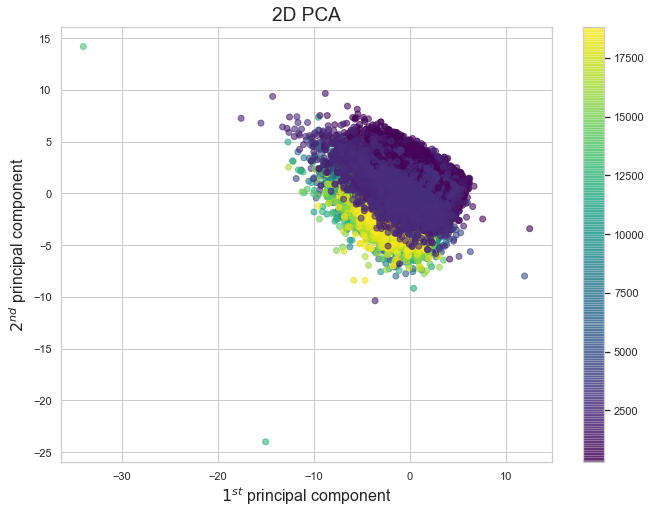

In [36]:
#Plotting data distribution in 2D space
plt.figure(figsize = (11, 8))
plt.xlabel(r"$1^{st}$ principal component", fontsize=16)
plt.ylabel(r"$2^{nd}$ principal component", fontsize=16)
plt.scatter(pca[0], pca[1], c=Y_pca, cmap='viridis', alpha=.6)
plt.title("2D PCA", fontsize = 19)
plt.colorbar()
plt.show()